In [1]:
import os
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import re

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', None)

### Finance Data

In [139]:
CLEAN_PATH = '../data/data_clean/us_school_districts.csv'

df = pd.read_csv(CLEAN_PATH)

In [391]:
finances_2016 = df[(df.YRDATA == 2016)]
finances_2016 = finances_2016.reset_index(drop=True)
finances_2016.head()

,STATE,ENROLL,NAME,YRDATA,TOTALREV,TFEDREV,TSTREV,TLOCREV,LOCRTAX,LOCRPROP,LOCREVPAR,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,TOTALEXP,TCURSPND,TSALWAGE,TEMPBENE,TCURINST,TCURSSVC,PPCSTOT,PPITOTAL,PPSTOTAL
0,Alabama,9609.0,AUTAUGA COUNTY SCHOOL DISTRICT,2016,80867,7447,53842,19578,6797.0,6775.0,NaN,100.0,9.2,66.6,24.2,76672,74185.0,43030.0,18122.0,43843,23941,7622.0,4563.0,2492.0
1,Alabama,30931.0,BALDWIN COUNTY SCHOOL DISTRICT,2016,338236,23710,145180,169346,49106.0,48902.0,NaN,100.0,7.0,42.9,50.1,299880,281647.0,156502.0,61621.0,164977,97231,8942.0,5332.0,3143.0
2,Alabama,912.0,BARBOUR COUNTY SCHOOL DISTRICT,2016,10116,2342,5434,2340,1209.0,1202.0,NaN,100.0,23.2,53.7,23.1,10070,9778.0,5079.0,2064.0,4907,3896,10621.0,5380.0,4272.0
3,Alabama,2842.0,EUFAULA CITY SCHOOL DISTRICT,2016,26182,3558,15900,6724,2844.0,2836.0,NaN,100.0,13.6,60.7,25.7,29843,25477.0,14015.0,5746.0,15302,7901,8851.0,5384.0,2780.0
4,Alabama,3322.0,BIBB COUNTY SCHOOL DISTRICT,2016,32486,3664,21846,6976,1716.0,1572.0,NaN,100.0,11.3,67.2,21.5,31662,30616.0,17107.0,7057.0,16407,11087,8931.0,4882.0,3337.0


### Map Data

In [392]:
# Used to map state codes to state names for map data
state_map = {
    1: 'Alabama',
    2: 'Alaska',
    4: 'Arizona',
    5: 'Arkansas',
    6: 'California',
    8: 'Colorado',
    9: 'Connecticut',
    10: 'Delaware',
    11: 'District of Columbia',
    12: 'Florida',
    13: 'Georgia',
    15: 'Hawaii',
    16: 'Idaho',
    17: 'Illinois',
    18: 'Indiana',
    19: 'Iowa',
    20: 'Kansas',
    21: 'Kentucky',
    22: 'Louisiana',
    23: 'Maine',
    24: 'Maryland',
    25: 'Massachusetts',
    26: 'Michigan',
    27: 'Minnesota',
    28: 'Mississippi',
    29: 'Missouri',
    30: 'Montana',
    31: 'Nebraska',
    32: 'Nevada',
    33: 'New Hampshire',
    34: 'New Jersey',
    35: 'New Mexico',
    36: 'New York',
    37: 'North Carolina',
    38: 'North Dakota',
    39: 'Ohio',
    40: 'Oklahoma',
    41: 'Oregon',
    42: 'Pennsylvania',
    44: 'Rhode Island',
    45: 'South Carolina',
    46: 'South Dakota',
    47: 'Tennessee',
    48: 'Texas',
    49: 'Utah',
    50: 'Vermont',
    51: 'Virginia',
    53: 'Washington',
    54: 'West Virginia',
    55: 'Wisconsin',
    56: 'Wyoming'
}

In [393]:
# Import and configure map data
map_2016 = gpd.read_file('../data/data_clean/unsd_map/unsd_compiled.shp')

# Rename state column to align with finance data - astype int
map_2016 = map_2016.rename(columns={'STATEFP': 'STATE'})
map_2016.STATE = map_2016.STATE.astype(int)

# Exclude US territories (Codes above 56)
map_2016 = map_2016[map_2016.STATE <= 56]

# Map state codes to names
map_2016.STATE = map_2016.STATE.map(state_map)

In [143]:
map_2016.head()

,STATE,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,Alabama,00001,0100001,Fort Rucker School District,00,KG,12,G5420,B,E,233059995,2735224,+31.4097368,-085.7458071,"POLYGON ((-85.86572 31.45470, -85.86543 31.454..."
1,Alabama,00003,0100003,Maxwell AFB School District,00,KG,12,G5420,B,E,8476761,566857,+32.3809438,-086.3637490,"POLYGON ((-86.37655 32.39358, -86.37621 32.393..."
2,Alabama,00005,0100005,Albertville City School District,00,KG,12,G5420,None,E,68731806,258708,+34.2631303,-086.2106600,"MULTIPOLYGON (((-86.25104 34.25266, -86.25060 ..."
3,Alabama,00006,0100006,Marshall County School District,00,PK,12,G5420,None,E,1267142967,103647100,+34.3739971,-086.3442702,"MULTIPOLYGON (((-86.10870 34.19063, -86.10873 ..."
4,Alabama,00007,0100007,Hoover City School District,00,KG,12,G5420,None,E,121693900,2594832,+33.3769487,-086.8055789,"MULTIPOLYGON (((-86.66393 33.40902, -86.66333 ..."


### Data Cleaning - 'NAME'

In [394]:
# Create maps to replace abbreviations and drop words
def create_maps(abbreviation_map, drop_map):
    abbreviation_map = {rf'\b{i}\b': word for i, word in my_map.items()}
    drop_map = {rf'\b{i}\b': word for i, word in drop_map.items()}
    
    return(abbreviation_map, drop_map)

my_map = {'schs': 'school district',
         'sch': 'school',
         'dist': 'district',
         'dst': 'district',
         'isd': 'school district',
         'pub': 'public',
         'ex': 'exempted',
         'vlg': 'village',
         'community': 'county',
         'comm': 'county',
         'com': 'county',
         'co': 'county',
         'inc': 'corporation',
         'ind': 'independent',
         'uni': 'unified',
         'unif': 'unified',
         'uf': 'union free',
         'hts': 'heights',
         'supv': 'supervisory',
         'twp': 'township',
         'cty': 'city',
         'ctl': 'central',
         'elem': 'elementary'}

my_drop_map = {'public': '',
            'school': '',
            'schools': '',
            'district': '',
            'municipal': '',
            'city': '',
            'town': '',
            'merged': '',
            'cusd': '',
            'usd': '',
            'reg': '',
            'joint': '',
            'jt': '',
            #'r': '',
            'voc': '' }

In [395]:
# Regex replacement dictionaries to clean district names
abbreviation_map, drop_map = create_maps(my_map, my_drop_map)

In [400]:
def clean_NAME(df):
    df.NAME = df.NAME.str.lower()
    
    # Replace abbreviations and drop non-essential words
    df.NAME = df.NAME.replace(abbreviation_map, regex=True)
    df.NAME = df.NAME.replace(drop_map, regex=True)
    
    # Drop 'r-' and 'r' from district codes [ need rX next]
    df.NAME = df.NAME.str.replace(rf" r-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" r ", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" re-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" re ", ' ', regex=True)
    
    # Drop extra district codes found in '()'
    df.NAME = df.NAME.str.replace("\([^()]*\)", '', regex=True)
    
    # Drop '#' and '.' and '-' from districts
    df.NAME = df.NAME.str.replace('#', '', regex=False)
    df.NAME = df.NAME.str.replace('.', '', regex=False)
    df.NAME = df.NAME.str.replace('-', ' ', regex=False)
    
    # Hawaii edge case
    df['NAME'][df.STATE == 'Hawaii'] = 'hawaii'
        
    # Cleanup whitespace
    df.NAME = df.NAME.str.rstrip()
    df.NAME = df.NAME.replace("\s+", ' ', regex=True)
    
    df = df.sort_values(['STATE', 'NAME'])
    return df

In [401]:
clean_f = clean_NAME(finances_2016)
clean_m = clean_NAME(map_2016)

# These states have disctrict codes in finance data but none in map data
extra_codes = ['Arizona', 
             'Arkansas', 
             'Minnesota', 
             'Missouri', 
             'Nebraska',
             'Oklahoma', 
             'Texas',
             'Washington', 
             'Wisconsin']


# Map data does not include district codes for the above states. Remove numbers from the above states
clean_f['NAME'][clean_f.STATE.isin(extra_codes)] = clean_f.NAME.str.replace(' \d+', '')

C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Combining Finance and Map data

In [402]:
# Merge on an exact match of state and name of district, 
# only keep the geomtry data and convert to geodataframe
merged_df = clean_f.merge(clean_m[['STATE', 'NAME', 'geometry']], 
                                how='inner', 
                                on=['STATE', 'NAME'])

finances_map_2016 = gpd.GeoDataFrame(merged_df, geometry=merged_df.geometry)

print("The merged data accounts for {}% of the map data set.".format((len(finances_map_2016) / len(map_2016)) * 100))
print("{} data points.".format(len(finances_map_2016)))
finances_map_2016.head()

The merged data accounts for 79.67128821963088% of the map data set.
8677 data points.


,STATE,ENROLL,NAME,YRDATA,TOTALREV,TFEDREV,TSTREV,TLOCREV,LOCRTAX,LOCRPROP,LOCREVPAR,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,TOTALEXP,TCURSPND,TSALWAGE,TEMPBENE,TCURINST,TCURSSVC,PPCSTOT,PPITOTAL,PPSTOTAL,geometry
0,Alabama,5214.0,albertville,2016,49795,7277,28885,13633,5125.0,4726.0,NaN,100.0,14.6,58.0,27.4,46778,43700.0,23204.0,9435.0,24173,15092,8226.0,4636.0,2895.0,"MULTIPOLYGON (((-86.25104 34.25266, -86.25060 ..."
1,Alabama,3102.0,alexander,2016,32454,3717,17018,11719,2703.0,2696.0,NaN,100.0,11.5,52.4,36.1,29642,28690.0,15665.0,6027.0,17613,8768,9031.0,5678.0,2827.0,"POLYGON ((-86.01390 32.82641, -86.01384 32.826..."
2,Alabama,1745.0,andalusia,2016,18650,2360,9571,6719,755.0,751.0,NaN,100.0,12.7,51.3,36.0,15978,15580.0,8073.0,3237.0,9218,5193,8868.0,5283.0,2976.0,"POLYGON ((-86.52252 31.31342, -86.52249 31.315..."
3,Alabama,2099.0,anniston,2016,23776,4344,11810,7622,4722.0,4711.0,NaN,100.0,18.3,49.7,32.1,24320,23883.0,12018.0,4843.0,12649,9344,11277.0,6026.0,4452.0,"MULTIPOLYGON (((-85.84967 33.69738, -85.84952 ..."
4,Alabama,2540.0,arab,2016,23606,1544,15096,6966,1219.0,1217.0,NaN,100.0,6.5,63.9,29.5,26202,23748.0,13565.0,5237.0,14569,7328,9217.0,5736.0,2885.0,"MULTIPOLYGON (((-86.46230 34.31094, -86.46030 ..."


In [421]:
# The count of districts in each state in each data set (finances, map, combined)
dps_f = clean_f.groupby(['STATE'])['NAME'].count()
dps_m = clean_m.groupby(['STATE'])['NAME'].count()
dps_c = finances_map_2016.groupby(['STATE'])['NAME'].count()

sum_of_percents = (dps_c / dps_m).sum()
percent_mapped = (sum_of_percents / len(dps_c / dps_m)) * 100

print("{} / 51 State Districts successfully mapped to finance data.".format(sum_of_percents))
print('{}% of the map data linked to finace data.'.format((percent_mapped)))
print('='*50)
print(dps_c / dps_m * 100)

#Max so far = 41.219774264973765

41.219774264973765 / 51 State Districts successfully mapped to finance data.
80.8230867940662% of the map data linked to finace data.
STATE
Alabama                  94.927536
Alaska                   66.037736
Arizona                  56.122449
Arkansas                 94.017094
California               93.313953
Colorado                 72.471910
Connecticut              95.652174
Delaware                100.000000
District of Columbia    100.000000
Florida                  95.522388
Georgia                  86.187845
Hawaii                  100.000000
Idaho                    89.565217
Illinois                 79.687500
Indiana                  84.827586
Iowa                     90.178571
Kansas                   83.916084
Kentucky                 83.040936
Louisiana                92.753623
Maine                    52.479339
Maryland                 91.666667
Massachusetts            89.047619
Michigan                 67.567568
Minnesota                54.601227
Mississippi         

In [405]:
# Used for viewing data sets by state
state = 'Missouri '

state_f = clean_f[clean_f.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
state_m = clean_m[clean_m.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
state_combined = finances_map_2016[finances_map_2016.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]

print("FINANCES ({})".format(len(state_f)))
print('='*15)
print(state_f)
print('='*75)

print("MAP ({})".format(len(state_m)))
print('='*15)
print(state_m)
print('='*75)

print('COMBINED ({})'.format(len(state_combined)))
print('='*15)
print(state_combined)

FINANCES (0)
Empty DataFrame
Columns: [STATE, NAME]
Index: []
MAP (0)
Empty DataFrame
Columns: [STATE, NAME]
Index: []
COMBINED (0)
Empty DataFrame
Columns: [STATE, NAME]
Index: []


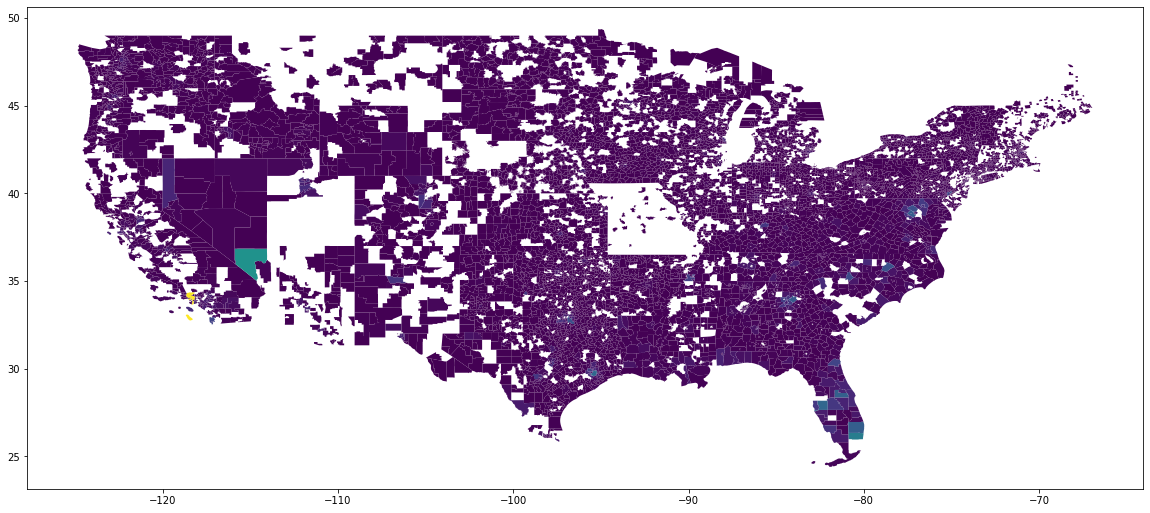

In [326]:
temp = finances_map_2016[~finances_map_2016.STATE.isin(['Alaska', 'Hawaii'])]
fig = temp.plot(column='ENROLL', figsize = (20,20))

# plt.xlim([-190,-50])
# plt.ylim([0,80])

plt.show()

### Some Stuff?

In [147]:
SCHEMA = ['YRDATA',
'NAME',
'ENROLL',
'TOTALREV',
'TFEDREV',
'TSTREV',
'TLOCREV',
'LOCRTAX',
'LOCRPROP',
#'LOCREVPAR',
'PCTTOTAL',
'PCTFTOT',
'PCTSTOT',
'PCTLTOT',
'TOTALEXP',
'TCURSPND',
'TSALWAGE',
'TEMPBENE',
'TCURINST',
'TCURSSVC',
'PPCSTOT',
'PPITOTAL',
'PPSTOTAL']

def n_largest_or_smallest(df, n, operation):
    """Return a sorted df of the n most/least funded districts

        Parameters:
            df (dataframe): the dataframe to be modified
            n (int): the number of districts to keep
            operation (str)['smallest' or 'largest']: whether to return most/least funded 
        Returns:
            new_df (dataframe): A sorted dataframe of the n most/least funded districts in each state
    """
    
    if operation == 'largest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nlargest(n, columns='TOTALREV')) 
    elif operation == 'smallest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nsmallest(n, columns='TOTALREV'))
    else:
        print("operation must be 'largest' or 'smallest'")
        return
    
    return new_df

In [ ]:
least_funded = n_largest_or_smallest(df_2016, 3, 'smallest')
most_funded = n_largest_or_smallest(df_2016, 3, 'largest')

least_funded.head()
most_funded.head()